# Use Seq2Seq Model to Predict the Calibrations
## Settings:
+ **Input**: the previous calibrations and luminosity;
+ **Output**: the future calibrations;
+ **Training data**: the data collected from the crystal 54,000 in the year of 2016.

## Two Cases:
1. **Case1**: We **do not** reuse the predicted values. For example, we **do not** use the predicted values at *t* to predict the *t+1* values. 
2. **Case2**: We **do** reuse the predicted values. For example, we **do** use the predicted values at *t* to predict the *t+1* values. 

## Main:
This is the main function/entry for our Seq2Seq model.

### Import packages/classes.
+ **seq2seq_model** defines the model;
+ **seq2seq_train** defines the training procedures;
+ **seq2seq_prediction** defines the prediction procedures;
+ **ecal_dataset_prep** defines the data preprocessing procedures.

In [1]:
#------ import packages ------#
from seq2seq_model import *
from seq2seq_train import *
from seq2seq_prediction import *
from ecal_dataset_prep import *

### Set up the hyper-parameters.
+ **input_len**: the time steps (sequence length) for input data;
+ **output_len**: the time steps (sequence length) for output data;
+ **stride**: the stide of the sequence/window (default: output_len);
+ **learning_rate**: the learning rate for our model;
+ **n_epochs**: the maximum epoch to train our model;
+ **print_step**: we print the training information per "print_step" epoch;
+ **batch_size**: the batch size to train our model;
+ **opt_alg**: the name of the optimization function (one should select one from {adam', 'sgd'});
+ **train_strategy**: different training strategies (one should select one from {'recursive', 'teacher_forcing', 'mixed'});
+ **teacher_forcing_ratio**: it is a float number in the range of 0-1; it will be ignored when train_strategy='recursive';
+ **hidden_size**: the number of features in the hidden state;
+ **num_layers**: the number of recurrent layers;
+ **gpu_id**: the gpu id;
+ **train_file**: the training csv file;
+ **val_file**: the validation csv file;
+ **test_file**: the test csv file;
+ **crystal_id**: the crystal's id;
+ **verbose**:set it to be True if print information is desired; otherwise, set it to False; default (False).

In [2]:
input_len = 24
output_len = 24
stride = output_len
learning_rate = 1e-3
n_epochs = 200
print_step = 1
batch_size = 128
if output_len>=48: batch_size = 32
opt_alg = 'adam'
train_strategy = 'recursive' #"Please select one of them---[recursive, teacher_forcing, mixed]!"
teacher_forcing_ratio = 0.5 # please set it in the range of [0,1]
hidden_size = 1024
num_layers = 2
gpu_id = 0
crystal_id = 54000
verbose = False
train_file_2016 = '../0_Dataset/interim/df_skimmed_xtal_{}_2016.csv'.format(crystal_id)
test_file_2017 = '../0_Dataset/interim/df_skimmed_xtal_{}_2017.csv'.format(crystal_id)
test_file_2018 = '../0_Dataset/interim/df_skimmed_xtal_{}_2018.csv'.format(crystal_id)
device = torch.device("cuda:{}".format(gpu_id) if torch.cuda.is_available() else "cpu")

### Create folders to keep the results

In [3]:
# folder to save figures
save_dir_vis_data = 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/vis_data/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)

# folder to save models
save_dir_models = 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/models/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)

# folders for case1
save_dir_case1_fig= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case1_fig/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)
save_dir_case1_csv= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case1_csv/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)

# folders for case2
save_dir_case2_fig= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case2_fig/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)
save_dir_case2_csv= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case2_csv/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)

dir_list = [save_dir_vis_data, save_dir_case1_fig, save_dir_case1_csv, save_dir_case2_fig, save_dir_case2_csv,save_dir_models]
for cur_dir in dir_list:
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)
        print('>>> {} has been created successfully!'.format(cur_dir))
    else:
        print('>>> {} is exist!'.format(cur_dir))

>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/vis_data/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/case1_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/case1_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/case2_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/case2_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/models/ is exist!


### Visualize the datasets (only show the calibration curve).

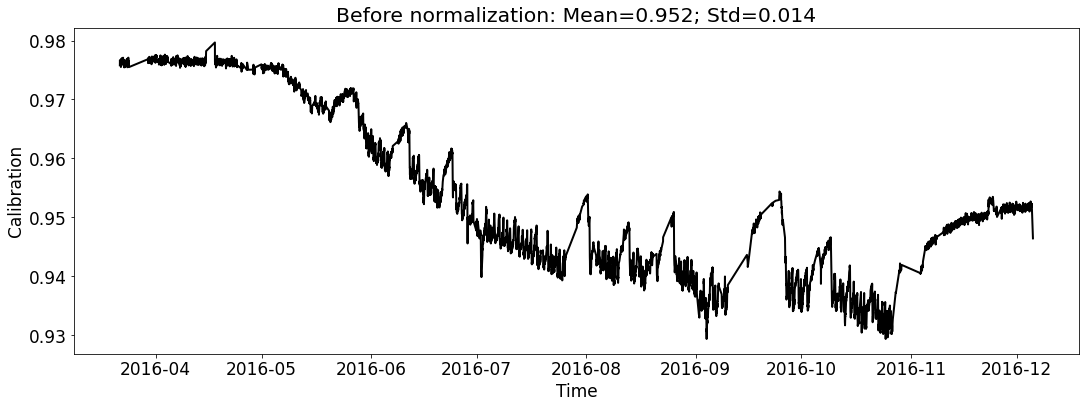

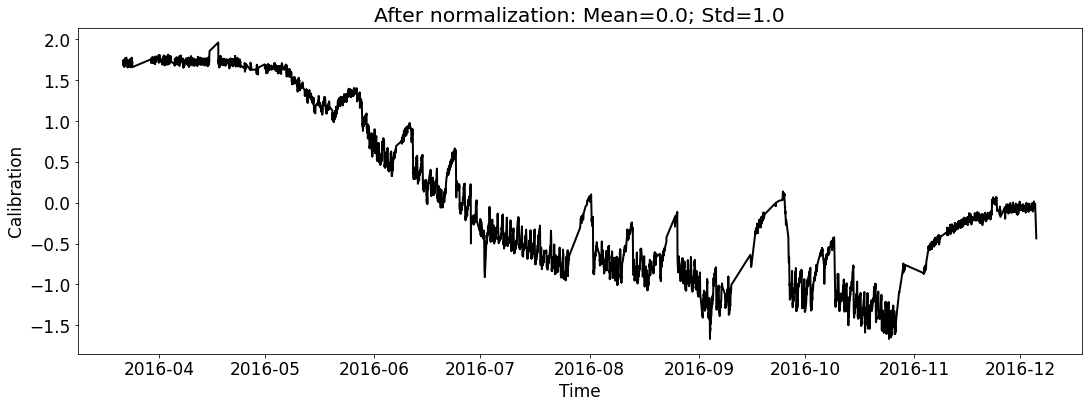

In [4]:
# for train_file_2016
fig_name_cali = os.path.join(save_dir_vis_data, '2016_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2016_cali_scaled.png')
ecal_dataset_prep_train_2016 = ECAL_Dataset_Prep(train_file_2016, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose)
ecal_dataset_prep_train_2016.start_processing()

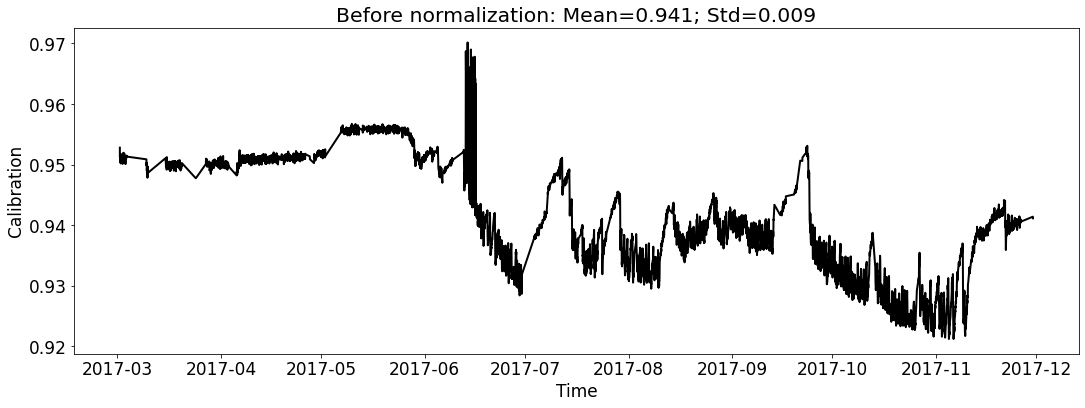

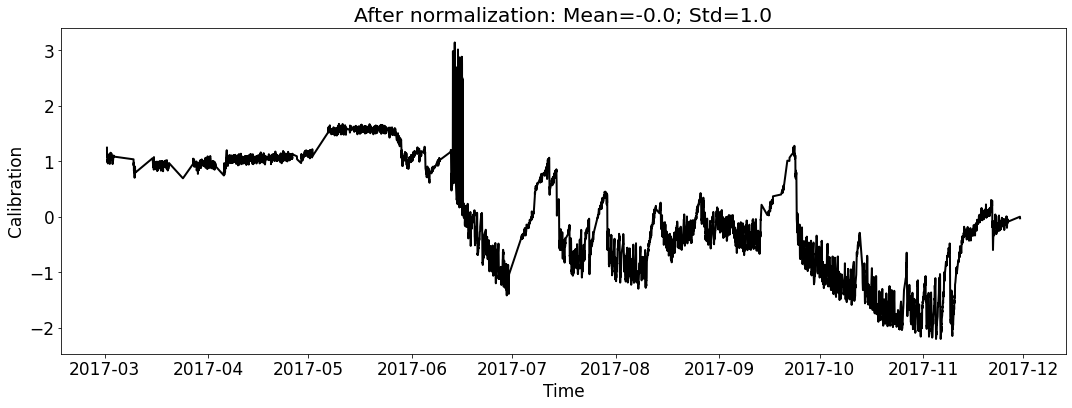

In [5]:
# for test_file_2017
fig_name_cali = os.path.join(save_dir_vis_data, '2017_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2017_cali_scaled.png')
ecal_dataset_prep_test_2017 = ECAL_Dataset_Prep(test_file_2017, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose)
ecal_dataset_prep_test_2017.start_processing()

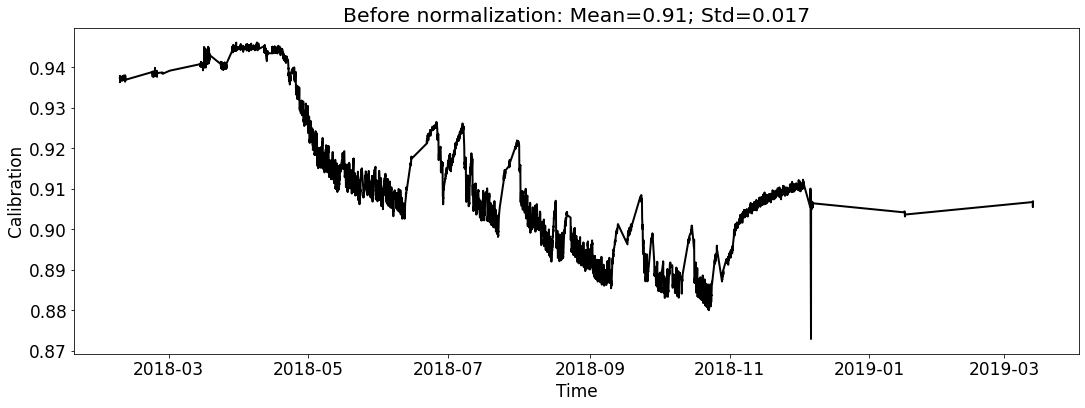

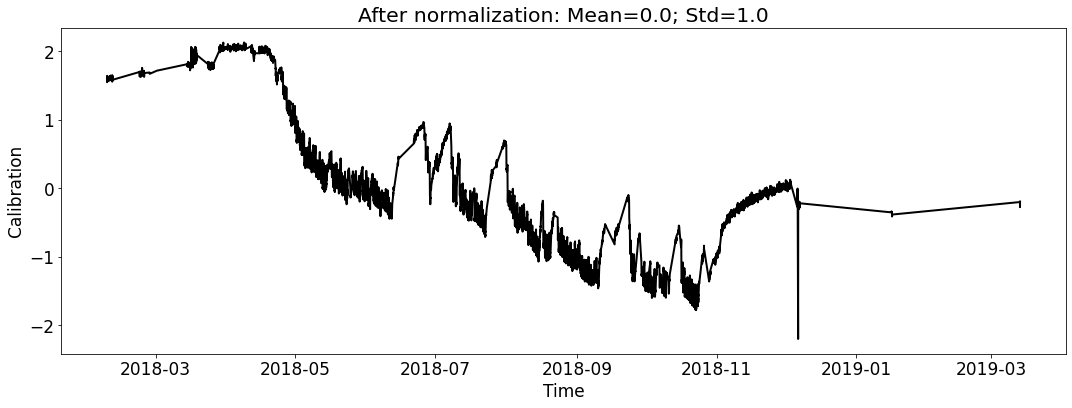

In [6]:
# for test_file_2018
fig_name_cali = os.path.join(save_dir_vis_data, '2018_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2018_cali_scaled.png')
ecal_dataset_prep_test_2018 = ECAL_Dataset_Prep(test_file_2018, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose)
ecal_dataset_prep_test_2018.start_processing()

### Create Seq2Seq model including an EncoderNet and a DecoderNet

In [7]:
X_train = ecal_dataset_prep_train_2016.torch_X
Y_train = ecal_dataset_prep_train_2016.torch_Y
lstm_encoder = LSTM_Encoder(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers)
lstm_decoder = LSTM_Decoder(input_size=Y_train.shape[2], hidden_size=hidden_size, num_layers=num_layers)
lstm_encoder.to(device)
lstm_decoder.to(device)
print(lstm_encoder)
print(lstm_decoder)

LSTM_Encoder(
  (lstm): LSTM(2, 1024, num_layers=2)
)
LSTM_Decoder(
  (lstm): LSTM(2, 1024, num_layers=2)
  (linear): Linear(in_features=1024, out_features=1, bias=True)
)


### Training Seq2Seq model

>>> Start training... (be patient: training time varies)


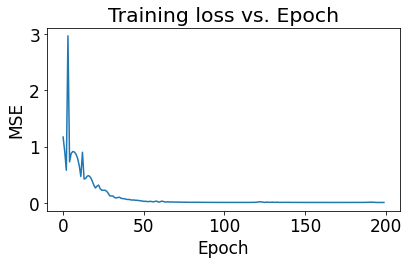

>>> Finish training!


In [8]:
loss_figure_name = os.path.join(save_dir_vis_data, '0_loss.png')
target_len = output_len
seq2sqe_train = Seq2Seq_Train(lstm_encoder,
                              lstm_decoder,
                              X_train,
                              Y_train,
                              n_epochs,
                              target_len,
                              batch_size,
                              learning_rate,
                              opt_alg,
                              print_step,
                              train_strategy,
                              teacher_forcing_ratio,
                              device,
                              loss_figure_name)
seq2sqe_train.start_train()

### Save trained models

In [9]:
 #after training, we also want to save our models
model_file_name = os.path.join(save_dir_models, 'lstm_encoder.pt')
save_model(lstm_encoder.eval(), model_file_name)
model_file_name = os.path.join(save_dir_models, 'lstm_decoder.pt')
save_model(lstm_decoder.eval(), model_file_name)

The trained model has been saved!
The trained model has been saved!


### Case1 Prediction:  do not use predictions as input to help the next-round prediction

>>>  case1 : start prediction...(be patient)


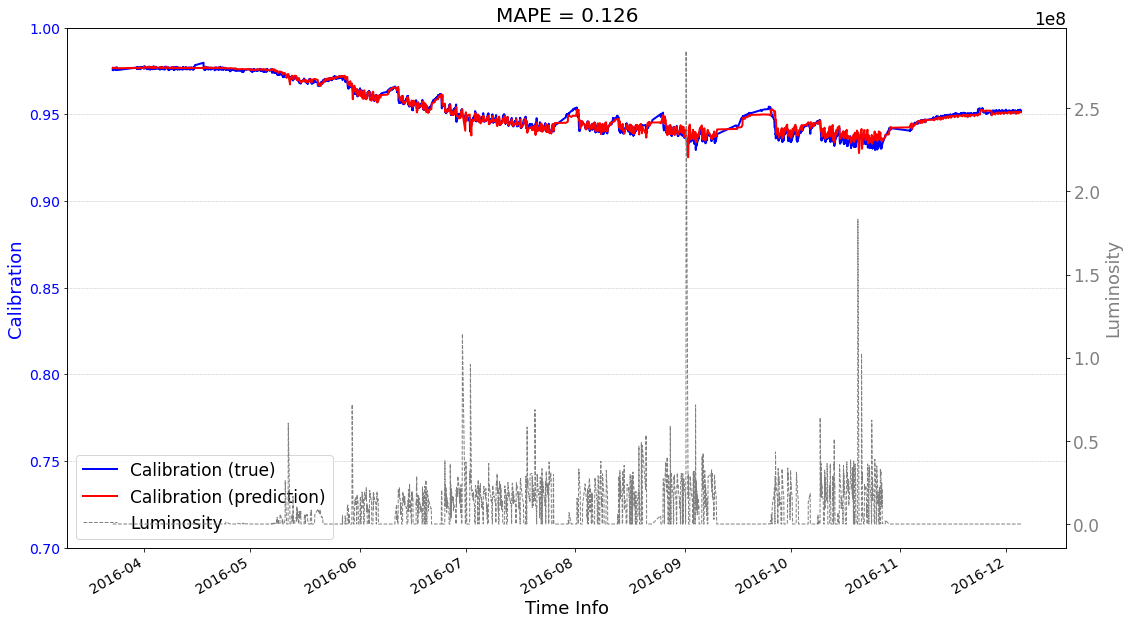

>>> Finish prediction!


In [10]:
# check its prediction on training data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_train_2016.np_X
Ytrain = ecal_dataset_prep_train_2016.np_Y
df = ecal_dataset_prep_train_2016.df_lumi
scaler_cali = ecal_dataset_prep_train_2016.scaler_cali
year = '2016'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)


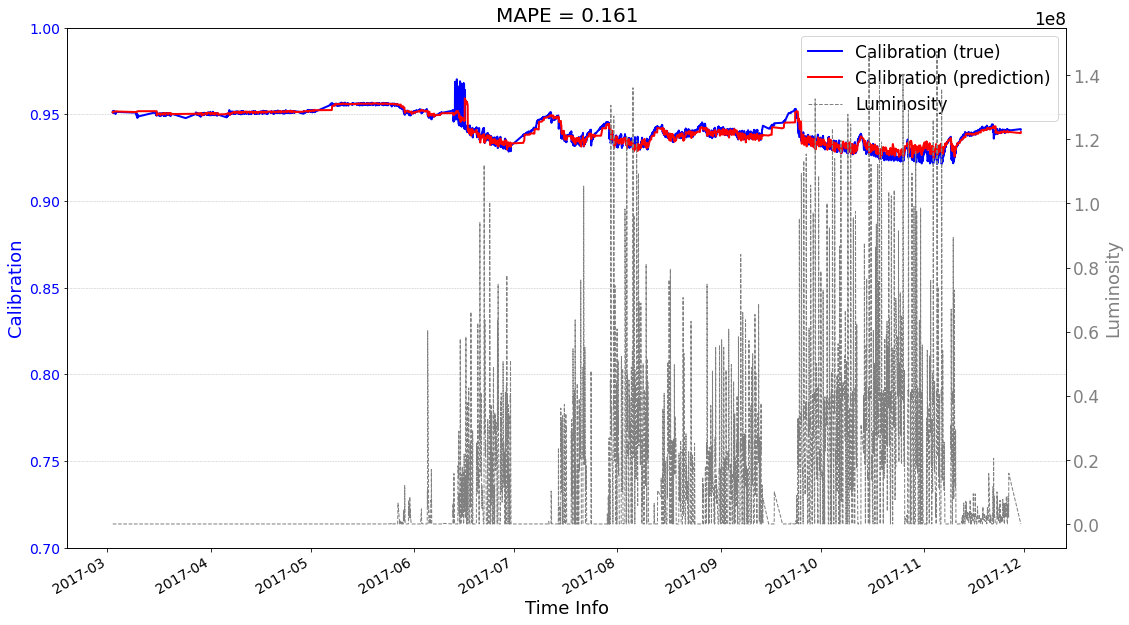

>>> Finish prediction!


In [11]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)


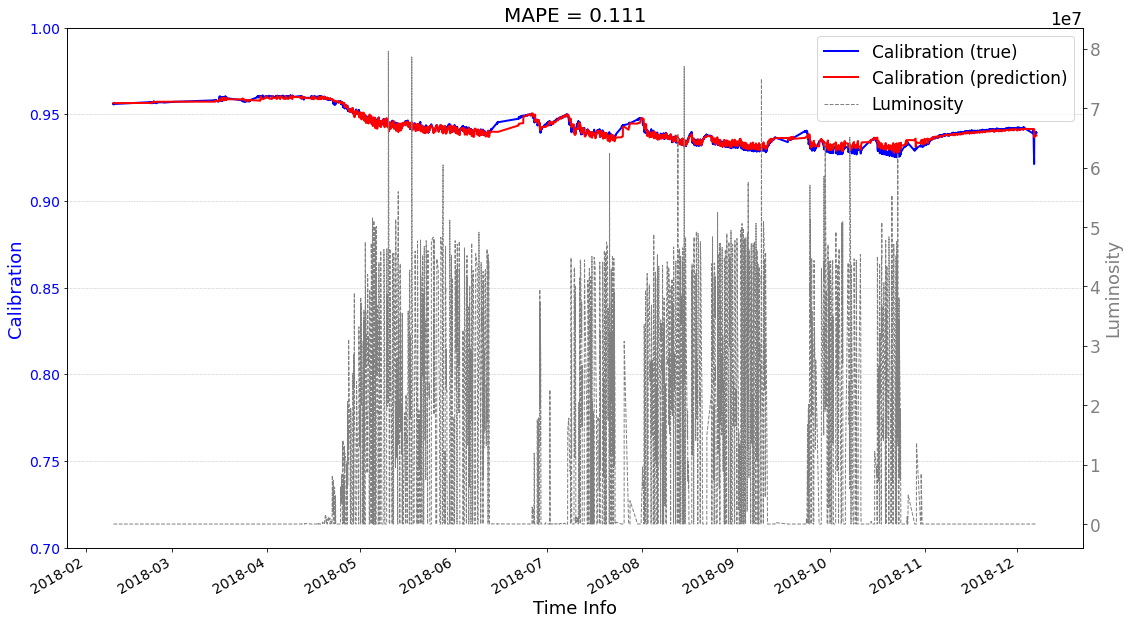

>>> Finish prediction!


In [12]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

### Case2 Prediction: use predictions as input to help the next-round prediction.

>>>  case2 : start prediction...(be patient)


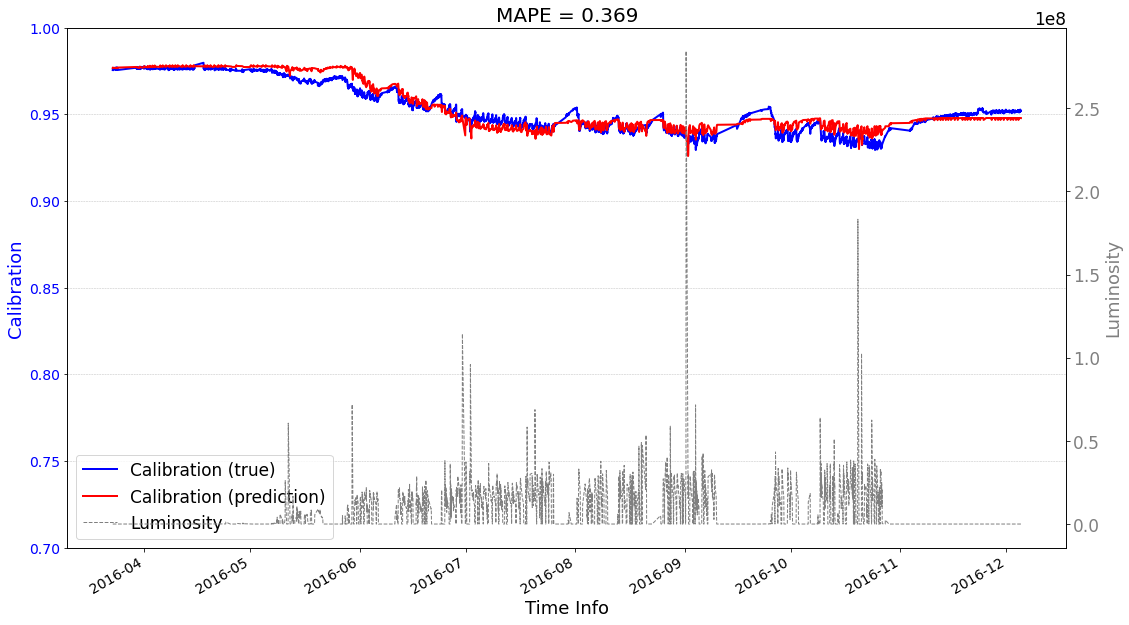

>>> Finish prediction!


In [13]:
# check its prediction on training data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_train_2016.np_X
Ytrain = ecal_dataset_prep_train_2016.np_Y
df = ecal_dataset_prep_train_2016.df_lumi
scaler_cali = ecal_dataset_prep_train_2016.scaler_cali
year = '2016'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)


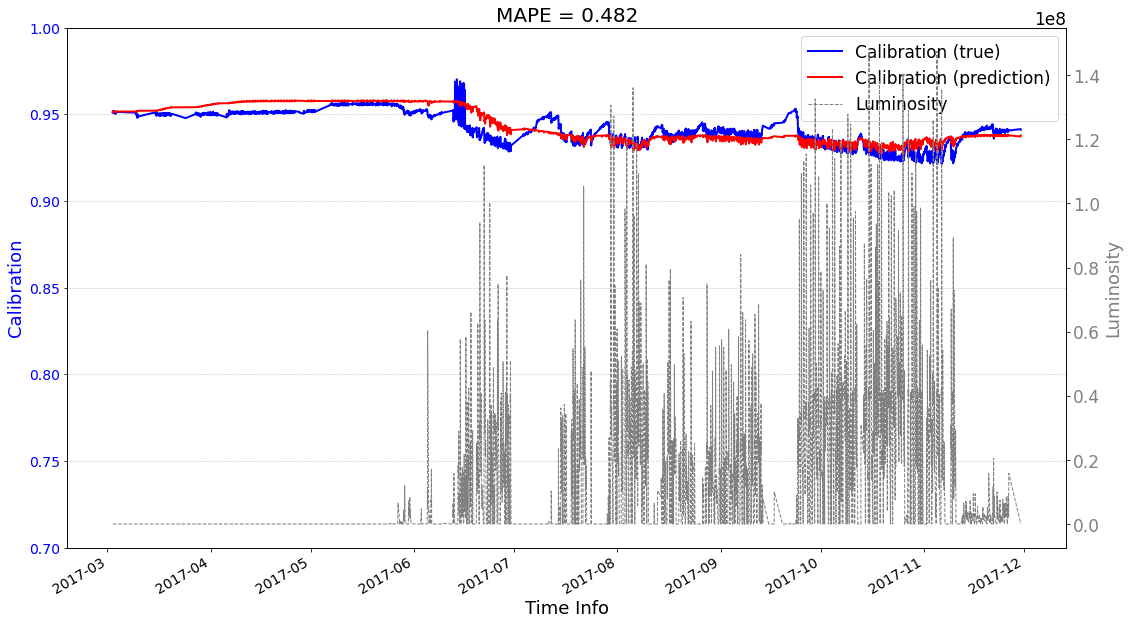

>>> Finish prediction!


In [14]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)


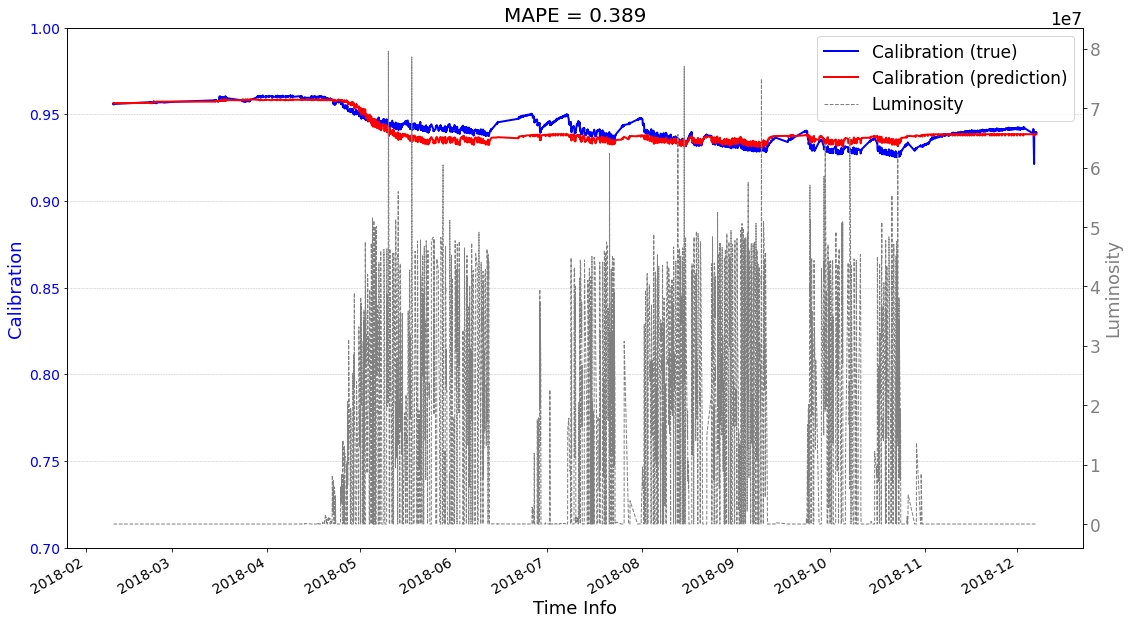

>>> Finish prediction!


In [15]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

### Test on other crystals

In [16]:
crystal_id = 54001
test_file_2016 = '../0_Dataset/interim/df_skimmed_xtal_{}_2016.csv'.format(crystal_id)
test_file_2017 = '../0_Dataset/interim/df_skimmed_xtal_{}_2017.csv'.format(crystal_id)
test_file_2018 = '../0_Dataset/interim/df_skimmed_xtal_{}_2018.csv'.format(crystal_id)

In [17]:

# folders for case1
save_dir_case1_fig= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case1_fig/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)
save_dir_case1_csv= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case1_csv/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)

# folders for case2
save_dir_case2_fig= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case2_fig/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)
save_dir_case2_csv= 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}/case2_csv/'.format(hidden_size, input_len, output_len, learning_rate,crystal_id)

dir_list = [save_dir_vis_data, save_dir_case1_fig, save_dir_case1_csv, save_dir_case2_fig, save_dir_case2_csv,save_dir_models]
for cur_dir in dir_list:
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)
        print('>>> {} has been created successfully!'.format(cur_dir))
    else:
        print('>>> {} is exist!'.format(cur_dir))

>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/vis_data/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54001/case1_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54001/case1_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54001/case2_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54001/case2_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000/models/ is exist!


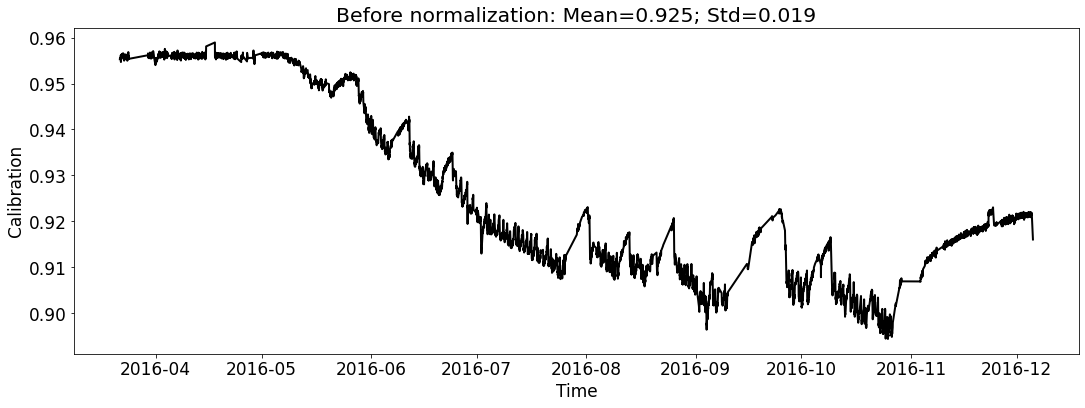

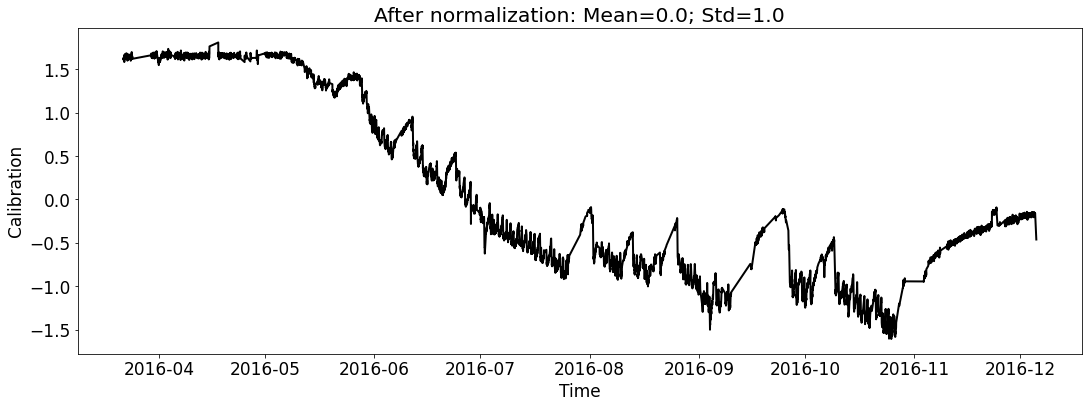

In [18]:
# for test_file_2016
fig_name_cali = os.path.join(save_dir_vis_data, '2016_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2016_cali_scaled.png')
ecal_dataset_prep_test_2016 = ECAL_Dataset_Prep(test_file_2016, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose)
ecal_dataset_prep_test_2016.start_processing()

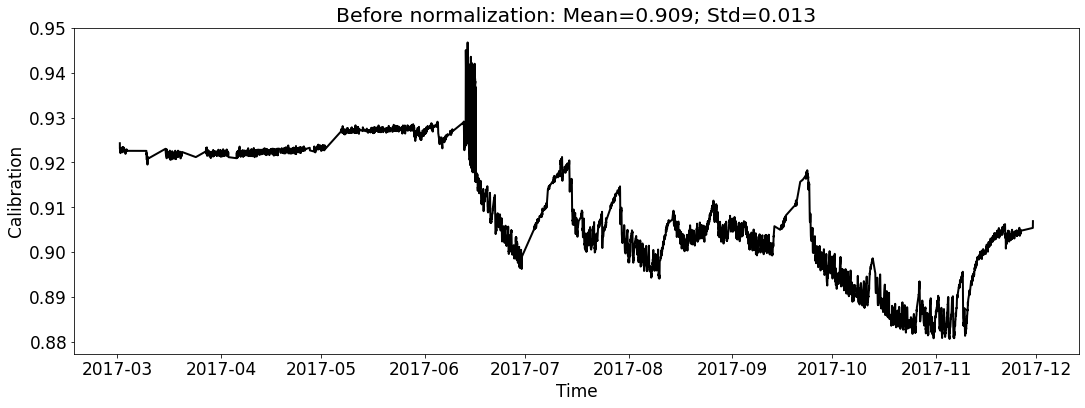

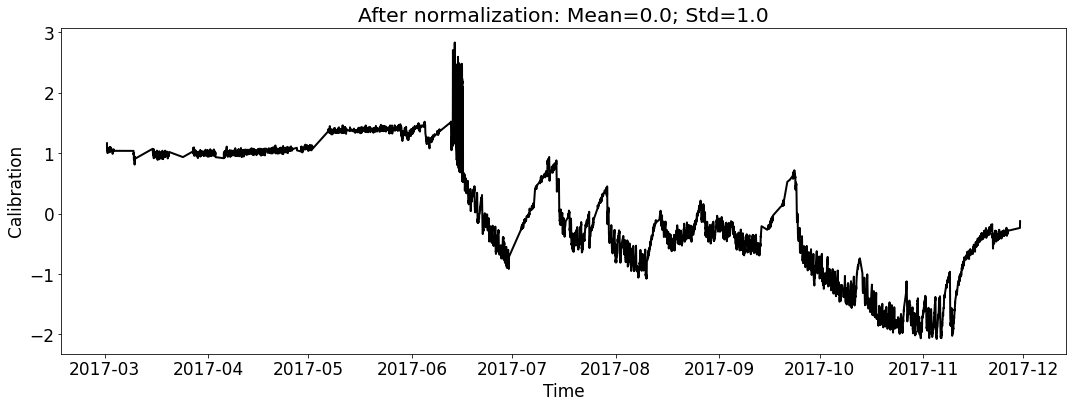

In [19]:
# for test_file_2017
fig_name_cali = os.path.join(save_dir_vis_data, '2017_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2017_cali_scaled.png')
ecal_dataset_prep_test_2017 = ECAL_Dataset_Prep(test_file_2017, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose)
ecal_dataset_prep_test_2017.start_processing()

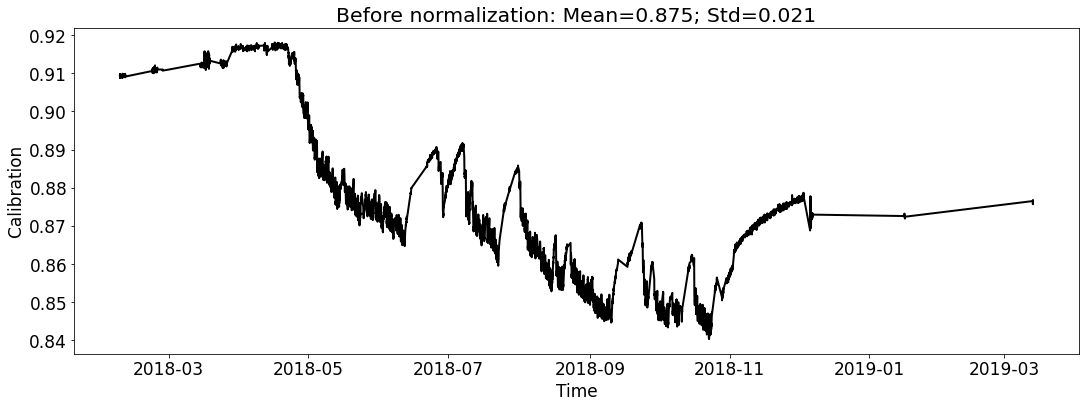

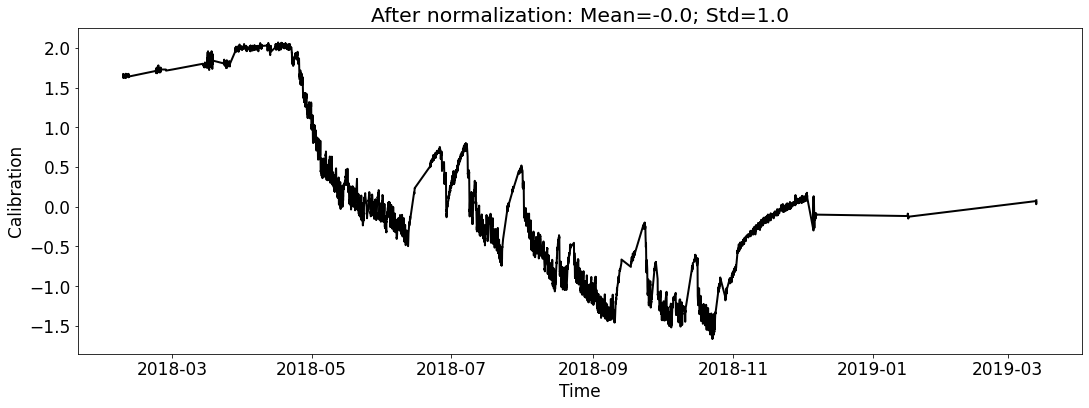

In [20]:
# for test_file_2018
fig_name_cali = os.path.join(save_dir_vis_data, '2018_cali_original.png')
fig_name_scaled_cali = os.path.join(save_dir_vis_data, '2018_cali_scaled.png')
ecal_dataset_prep_test_2018 = ECAL_Dataset_Prep(test_file_2018, 
                                                 input_len, 
                                                 output_len, 
                                                 stride, 
                                                 fig_name_cali, 
                                                 fig_name_scaled_cali,
                                                 verbose)
ecal_dataset_prep_test_2018.start_processing()

#### Case1 Prediction:  do not use prediction as input to help the next-round prediction

>>>  case1 : start prediction...(be patient)


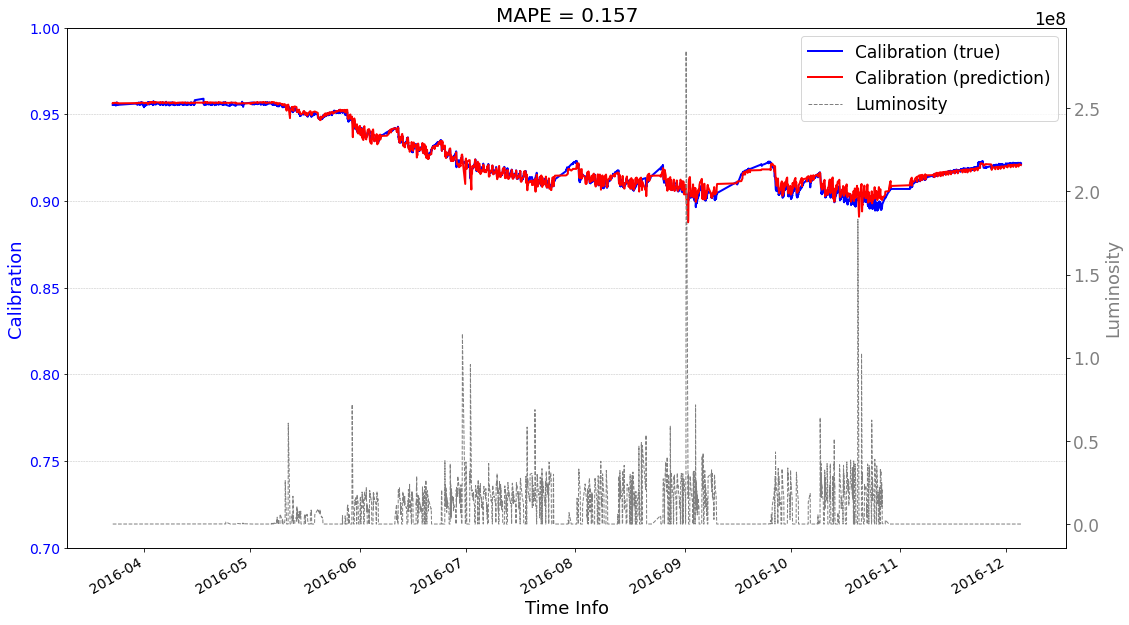

>>> Finish prediction!


In [21]:
# check its prediction on test data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2016.np_X
Ytrain = ecal_dataset_prep_test_2016.np_Y
df = ecal_dataset_prep_test_2016.df_lumi
scaler_cali = ecal_dataset_prep_test_2016.scaler_cali
year = '2016'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)


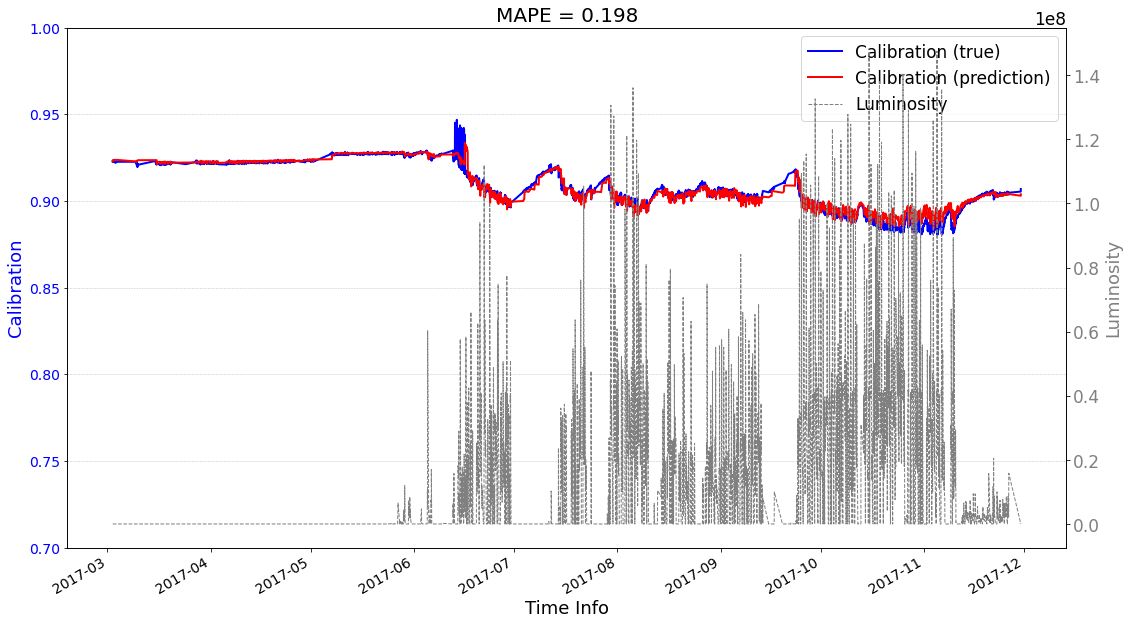

>>> Finish prediction!


In [22]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case1 : start prediction...(be patient)


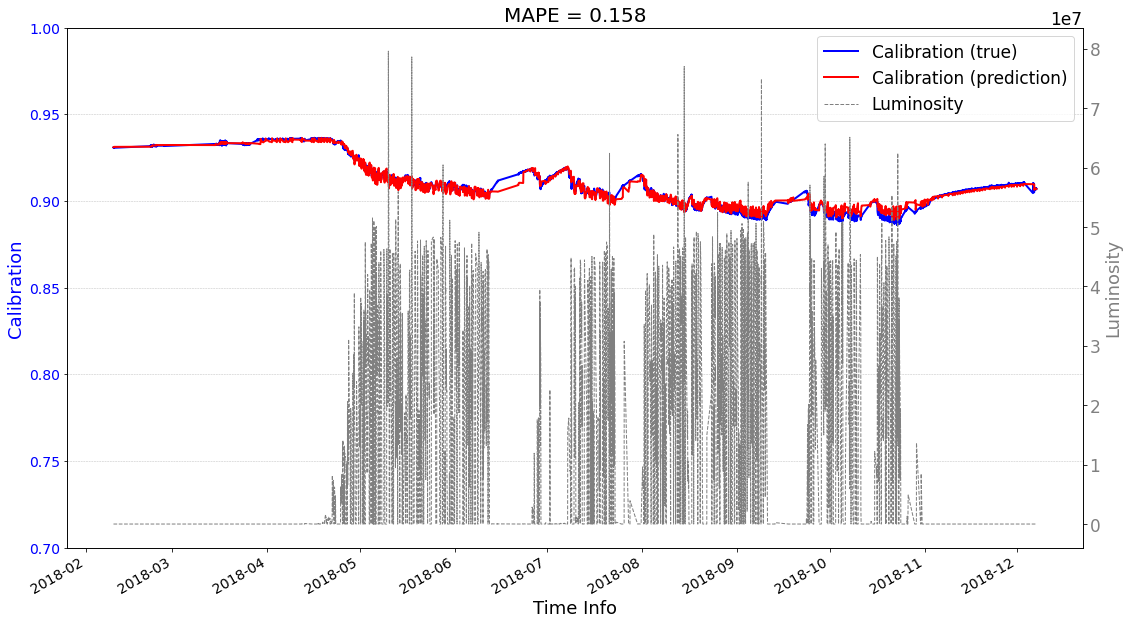

>>> Finish prediction!


In [23]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case1'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

#### Case2 Prediction: use predictions as input to help the next-round prediction.

>>>  case2 : start prediction...(be patient)


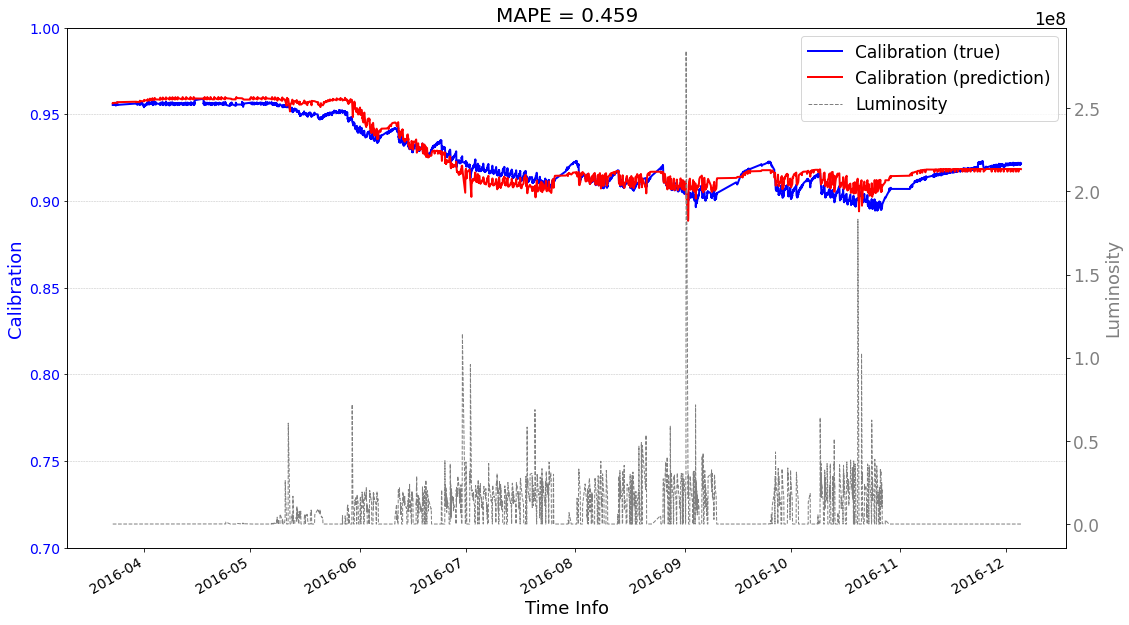

>>> Finish prediction!


In [24]:
# check its prediction on test data
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2016.np_X
Ytrain = ecal_dataset_prep_test_2016.np_Y
df = ecal_dataset_prep_test_2016.df_lumi
scaler_cali = ecal_dataset_prep_test_2016.scaler_cali
year = '2016'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)


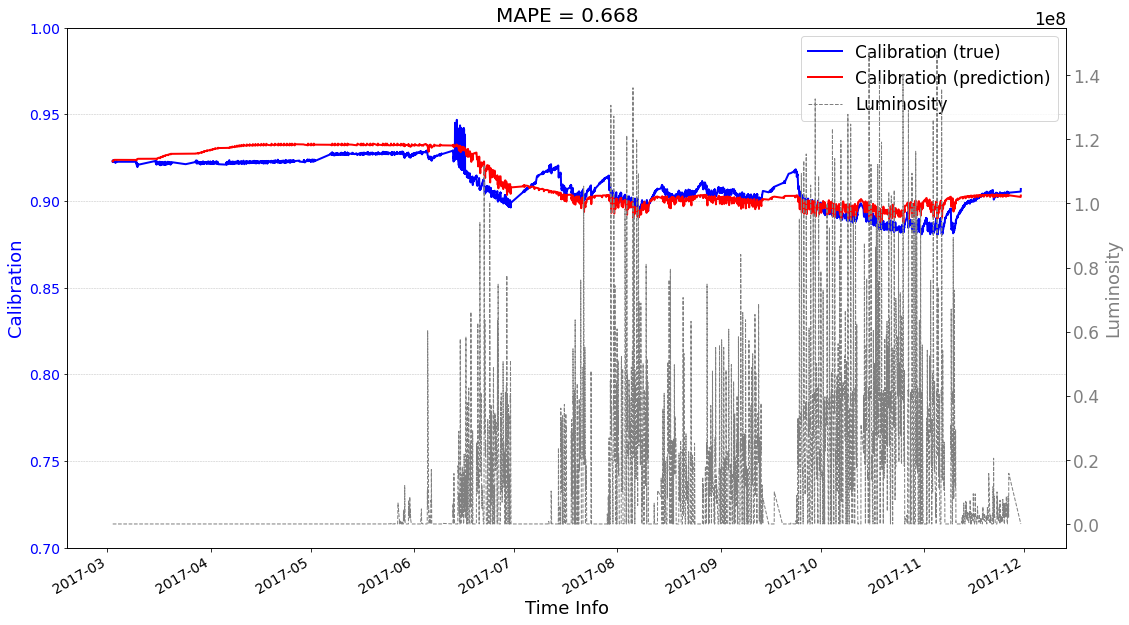

>>> Finish prediction!


In [25]:
# check its prediction on test data-2017
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2017.np_X
Ytrain = ecal_dataset_prep_test_2017.np_Y
df = ecal_dataset_prep_test_2017.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2017'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()

>>>  case2 : start prediction...(be patient)


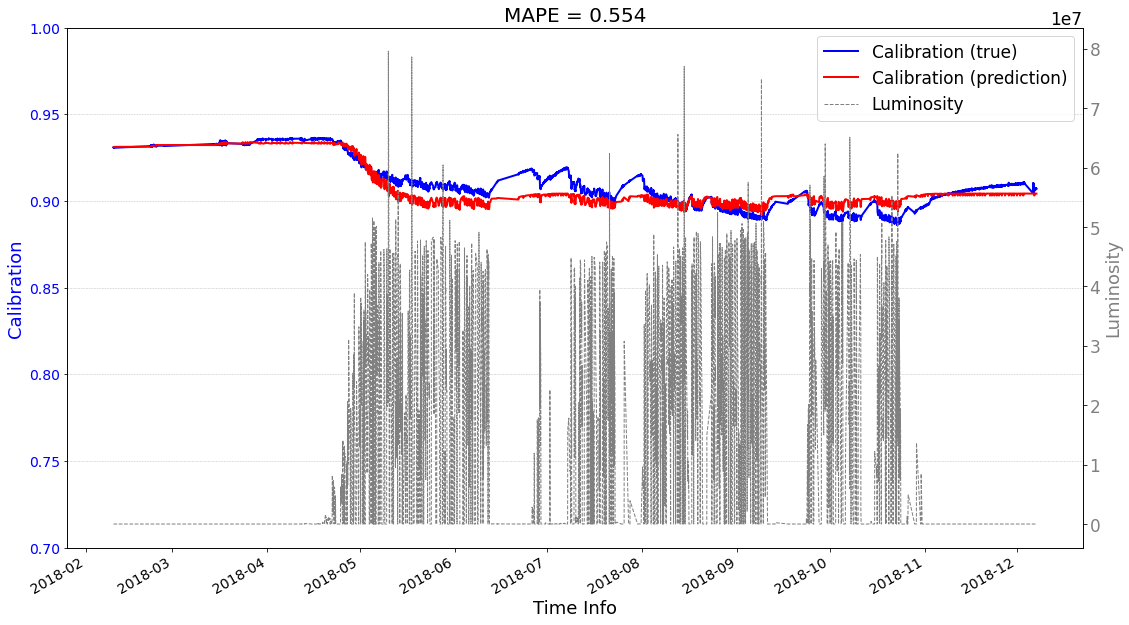

>>> Finish prediction!


In [26]:
# check its prediction on test data-2018
# Please note that here, the data are in the numpy format, not the tensor format
Xtrain = ecal_dataset_prep_test_2018.np_X
Ytrain = ecal_dataset_prep_test_2018.np_Y
df = ecal_dataset_prep_test_2018.df_lumi
scaler_cali = ecal_dataset_prep_test_2017.scaler_cali
year = '2018'
test_case = 'case2'
fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}.png'.format(test_case,year))
fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}.png'.format(test_case,year))
metric_file = os.path.join(save_dir_case1_csv, '{}_{}.csv'.format(test_case,year))
seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                        lstm_decoder,
                                        Xtrain,
                                        Ytrain,
                                        df,
                                        scaler_cali,
                                        device,
                                        fig_name_mape,
                                        fig_name_mse,
                                        metric_file,
                                        test_case)
seq2seq_prediction.start_prediction()